In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from collections import defaultdict
import os
import pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson

from itertools import combinations
from scipy.stats import chi2

In [2]:
df = pd.read_csv('data/df_level2.csv')
df

,CNTSCHID,CNT,PRIVATESCH,STRATIO,SCHSIZE,sum_MATHbelow,mean_ESCS,mean_ESCS_std,Y_MATH,Y_BIN_MATH
0,800004,Albania,public,9.7619,205,11,-1.152958,-0.268234,5,1
1,800006,Albania,public,18.0000,315,15,-1.343747,-0.565595,5,1
2,800007,Albania,public,4.7368,45,2,-2.401967,-2.214922,4,1
3,800008,Albania,private,13.8125,221,6,-0.135900,1.316941,3,1
4,800009,Albania,public,16.9691,823,19,-0.560240,0.655569,2,0
...,...,...,...,...,...,...,...,...,...,...
12615,97500358,B-S-J-Z (China),public,8.0786,1131,0,0.828180,1.595021,0,0
12616,97500359,B-S-J-Z (China),public,11.3202,2298,0,-0.178994,0.251551,0,0
12617,97500360,B-S-J-Z (China),public,9.7932,2605,0,0.190169,0.743977,0,0
12618,97500361,B-S-J-Z (China),public,11.7941,2005,3,-0.929946,-0.750143,0,0


In [3]:
import numpy as np
from scipy import stats

observed_data = df.loc[df.CNT=='United Kingdom', 'Y_MATH']
lambda_obs = np.mean(observed_data)
lenght = len(observed_data)

X = pd.DataFrame({'abs_freq': observed_data.value_counts(sort=False)})
X['value'] = X.index 
X = X.sort_values(by=['value'])
X.index = range(len(X))
X['rel_freq'] = X['abs_freq'] / np.sum(X['abs_freq'])
X['teor_freq'] = stats.poisson.pmf(X.value, lambda_obs)

degf = len(X) - 1 - 1

sum_ = X[['abs_freq', 'rel_freq', 'teor_freq']]
sum_['merging'] = sum_.index

j = 0
while(j<len(sum_)-1):
    if sum_.iloc[j]['abs_freq'] < 6:
        sum_.loc[[j+1], ['merging']] = j
        sum_ = sum_.groupby(['merging']).agg({'abs_freq':'sum','rel_freq':'sum', 'teor_freq':'sum'}).reset_index()
    else:
        j = j + 1
sum_

,merging,abs_freq,rel_freq,teor_freq
0,0,8,0.102564,0.228925
1,1,38,0.487179,0.337518
2,2,25,0.320513,0.248812
3,3,6,0.076923,0.180640
4,6,1,0.012821,0.003266


## Opzione 1) aggregate windows with < 5

In [4]:
import numpy as np
from scipy import stats

# https://www.edutecnica.it/calcolo/ada/ada.htm

p_values = pd.DataFrame({'Country' : df.CNT.unique(), 'p_value' : np.zeros(df.CNT.nunique())})

for i in df.CNT.unique():

    observed_data = df.loc[df.CNT==i, 'Y_MATH']
    lambda_obs = np.mean(observed_data)
    lenght = len(observed_data)

    X = pd.DataFrame({'abs_freq': observed_data.value_counts(sort=False)})
    X['value'] = X.index 
    X = X.sort_values(by=['value'])
    X.index = range(len(X))
    X['rel_freq'] = X['abs_freq'] / np.sum(X['abs_freq'])
    X['teor_freq'] = stats.poisson.pmf(X.value, lambda_obs)

    sum_ = X[['abs_freq', 'rel_freq', 'teor_freq']]
    sum_['merging'] = sum_.index

    j = 0
    while(j<len(sum_)-1):
        if sum_.iloc[j]['abs_freq'] < 5:
            sum_.loc[[j+1], ['merging']] = j
            sum_ = sum_.groupby(['merging']).agg({'abs_freq':'sum','rel_freq':'sum', 'teor_freq':'sum'}).reset_index()
        else:
            j = j + 1
    
    degf = len(sum_) - 1 - 1

    Q = ((sum_['rel_freq'] - sum_['teor_freq'])**2/sum_['teor_freq']).sum()

    p_value = 1 - stats.chi2.cdf(Q, degf)
    print(i)
    print(p_value)
    print('\n')

    idx = p_values[p_values['Country'] == i].index[0]
    p_values.loc[[idx], ['p_value']] = p_value

Albania
0.9960767037214219


Baku (Azerbaijan)
0.9953229229164552


Argentina
0.9984867892505167


Australia
0.0


Brazil
0.0


Brunei Darussalam
2.9960478542534474e-12


Chile
0.0


Chinese Taipei
0.13101988303718182


Colombia
0.9290280645127835


Costa Rica
0.9995979949368129


Denmark
0.9998522658247802


Dominican Republic
0.999908284817811


Estonia
0.9990223939490932


France
0.982407368738727


Georgia
0.9999996220546864


Greece
0.0


Indonesia
0.0


Ireland
0.9994982190151159


Israel
0.9653184842227016


Italy
0.0


Japan
0.0


Kazakhstan
0.993592566364847


Jordan
0.9997877847065456


Lebanon
0.0


Lithuania
0.9999015610354841


Luxembourg
0.45086703256087324


Malaysia
0.8751681592626898


Malta
0.16152426867125602


Mexico
0.8584813287800375


Moldova
0.9991316750967748


Morocco
0.9198949982806972


Panama
0.9867177028967458


Peru
0.9778172283224821


Philippines
0.9605972769859593


Poland
0.0


Portugal
1.887379141862766e-15


Qatar
0.01239587257247765


Saudi Arabia


## Opzione 2) leave all the windows as they are

In [5]:
import numpy as np
from scipy import stats

# https://www.edutecnica.it/calcolo/ada/ada.htm

p_values = pd.DataFrame({'Country' : df.CNT.unique(), 'p_value' : np.zeros(df.CNT.nunique())})

for i in df.CNT.unique():

    observed_data = df.loc[df.CNT==i, 'Y_MATH']
    lambda_obs = np.mean(observed_data)
    lenght = len(observed_data)

    X = pd.DataFrame({'abs_freq': observed_data.value_counts(sort=False)})
    X['value'] = X.index 
    X = X.sort_values(by=['value'])
    X.index = range(len(X))
    X['rel_freq'] = X['abs_freq'] / np.sum(X['abs_freq'])
    X['teor_freq'] = stats.poisson.pmf(X.value, lambda_obs)
    
    degf = len(X) - 1 - 1

    Q = ((X['rel_freq'] - X['teor_freq'])**2/X['teor_freq']).sum()

    p_value = 1 - stats.chi2.cdf(Q, degf)
    print(i)
    print(p_value)
    print('\n')

    idx = p_values[p_values['Country'] == i].index[0]
    p_values.loc[[idx], ['p_value']] = p_value

Albania
0.0


Baku (Azerbaijan)
0.0


Argentina
0.0


Australia
0.0


Brazil
0.0


Brunei Darussalam
0.0


Chile
0.0


Chinese Taipei
0.0


Colombia
0.0


Costa Rica
0.0


Denmark
0.9999932365065436


Dominican Republic
0.0


Estonia
0.02173178733481962


France
0.0


Georgia
0.0


Greece
0.0


Indonesia
0.0


Ireland
5.440092820663267e-15


Israel
0.0


Italy
0.0


Japan
0.0


Kazakhstan
0.0


Jordan
0.0


Lebanon
0.0


Lithuania
1.5519677809550103e-07


Luxembourg
0.9950842839140758


Malaysia
0.9700816609456282


Malta
0.0


Mexico
0.0


Moldova
0.0


Morocco
0.0


Panama
0.0


Peru
0.0


Philippines
0.0


Poland
0.0


Portugal
0.0


Qatar
0.0


Saudi Arabia
0.0


Singapore
0.0


Slovak Republic
0.0


Spain
0.0


Sweden
0.0


Switzerland
0.0


Thailand
0.0


United Arab Emirates
0.0


Turkey
0.0


United Kingdom
0.998493175776957


United States
0.0


Uruguay
0.0


B-S-J-Z (China)
0.0




## Some plots (qqplots for Poisson)

Albania


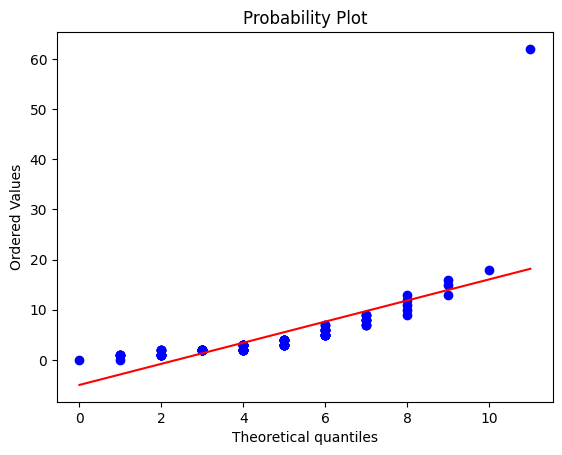

Baku (Azerbaijan)


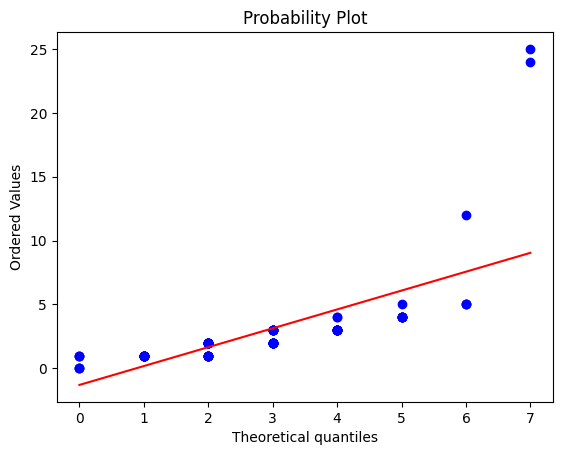

Argentina


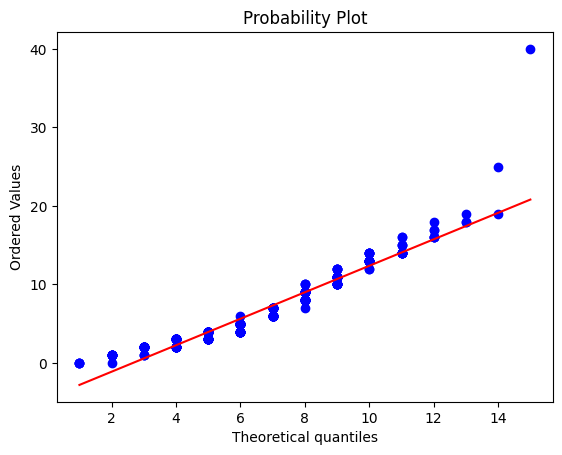

Australia


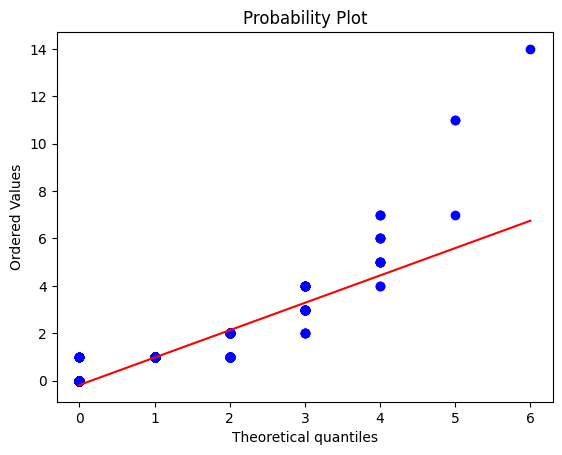

Brazil


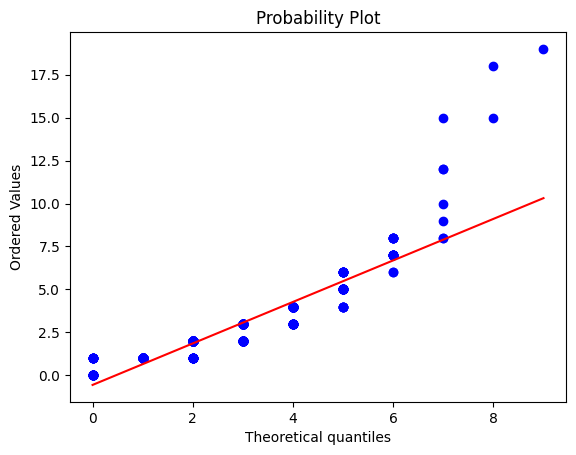

Brunei Darussalam


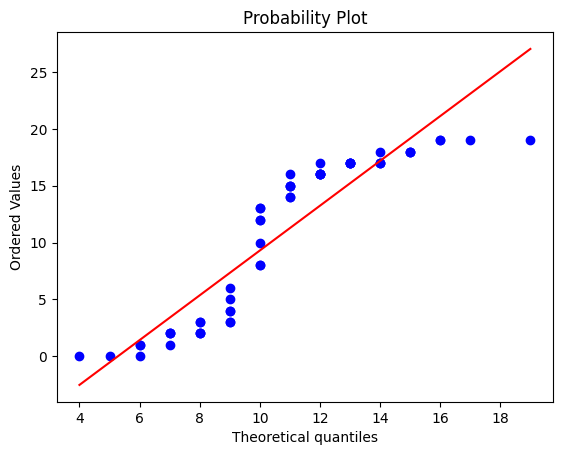

Chile


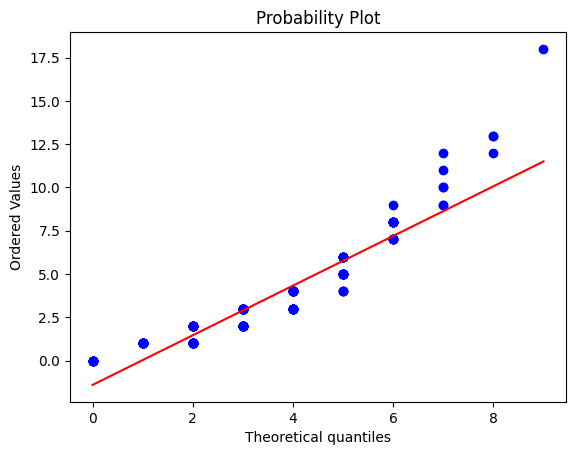

Chinese Taipei


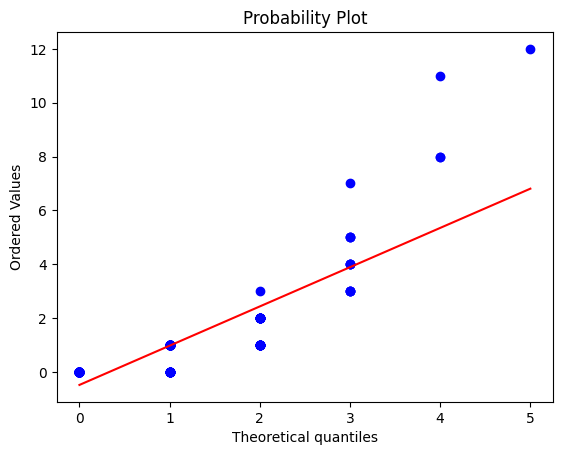

Colombia


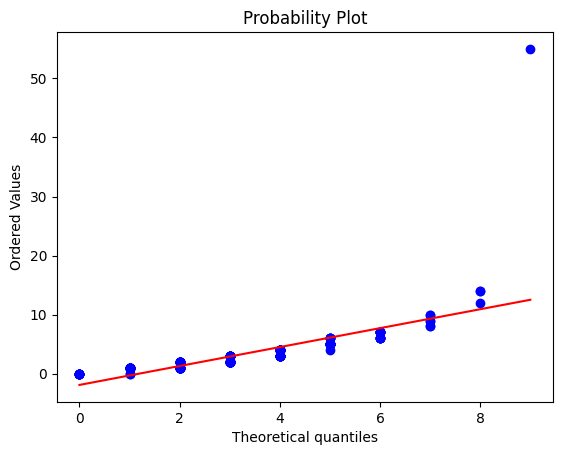

Costa Rica


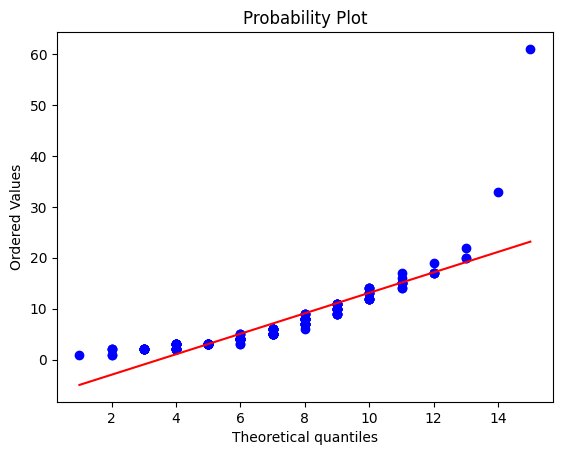

Denmark


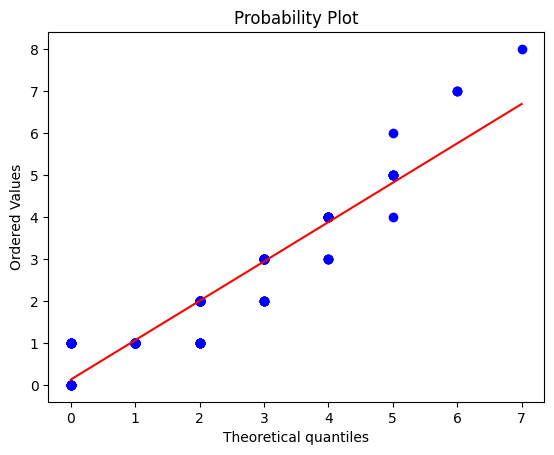

Dominican Republic


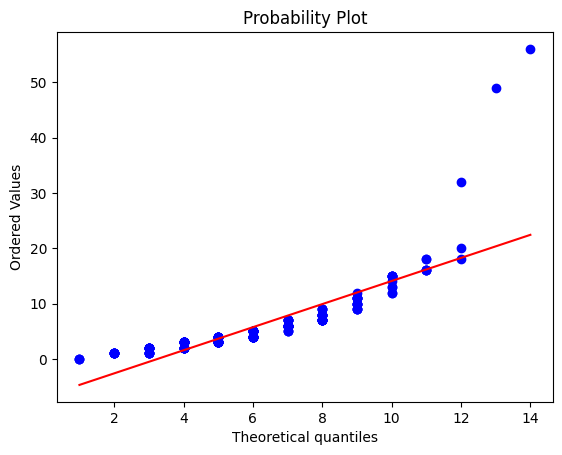

Estonia


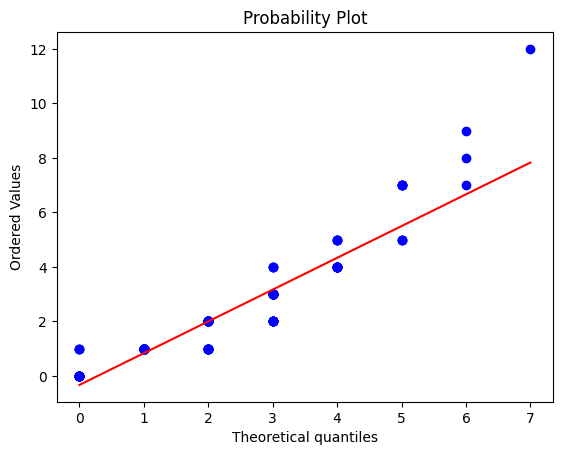

France


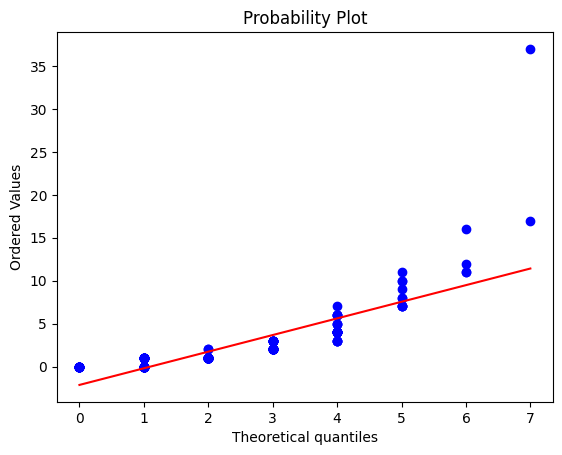

Georgia


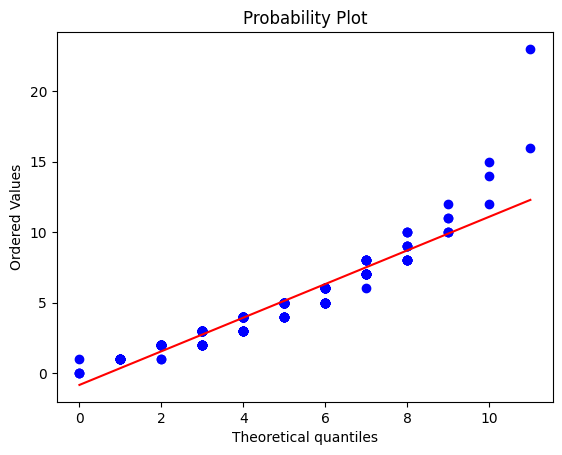

Greece


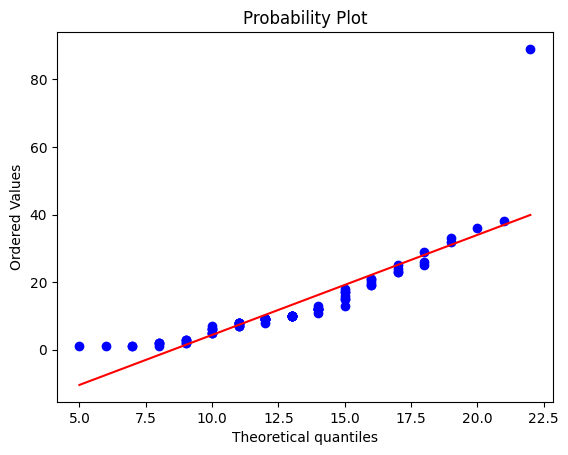

Indonesia


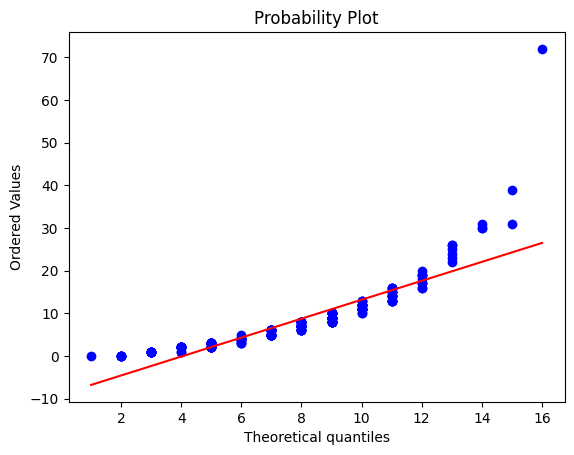

Ireland


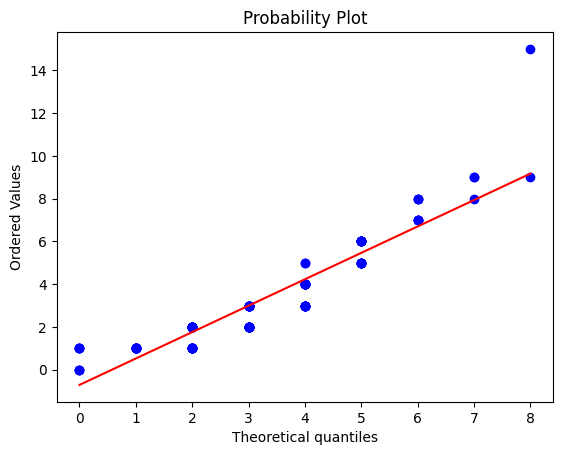

Israel


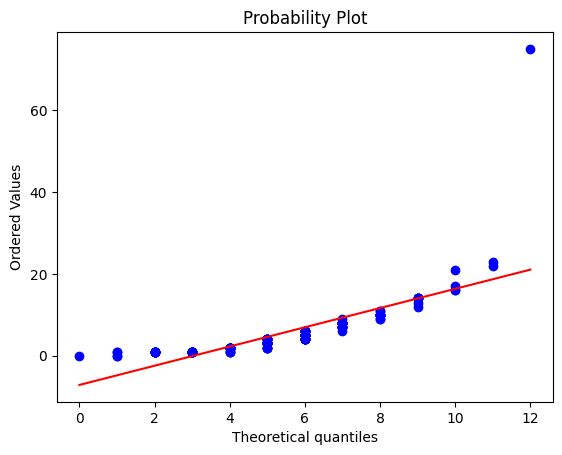

Italy


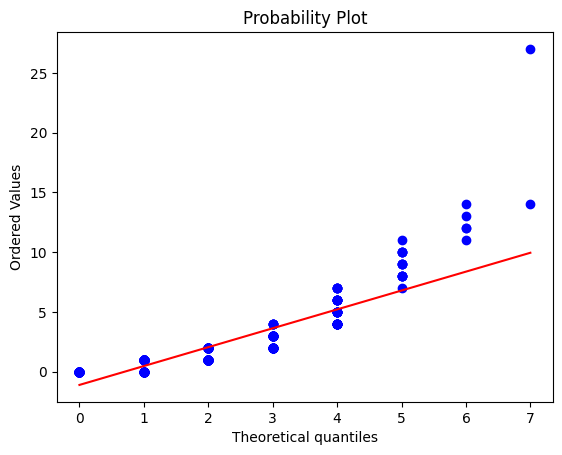

Japan


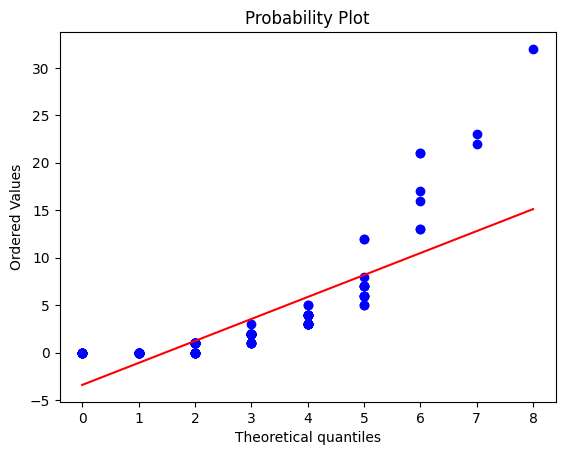

Kazakhstan


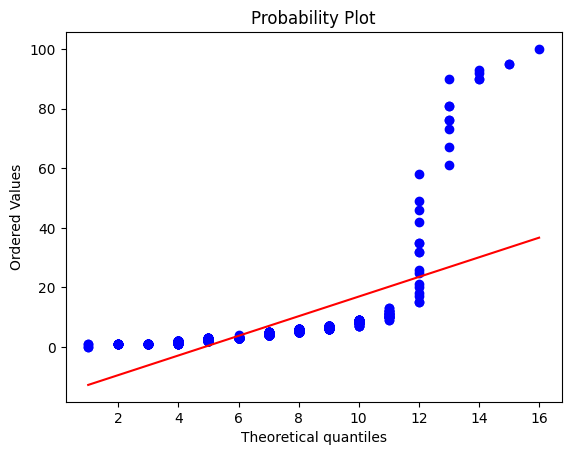

Jordan


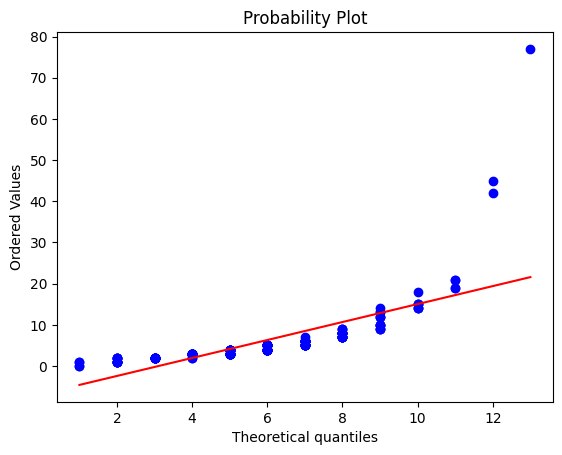

Lebanon


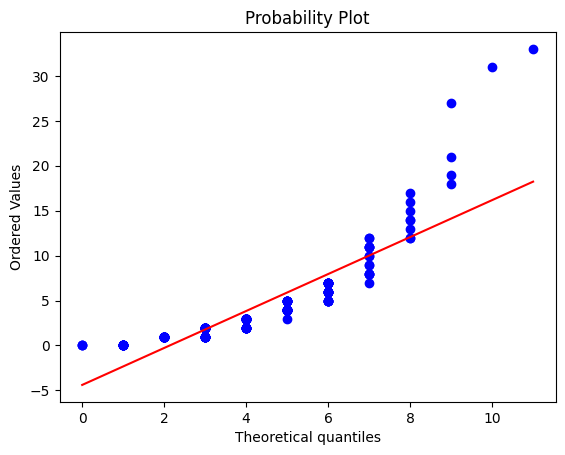

Lithuania


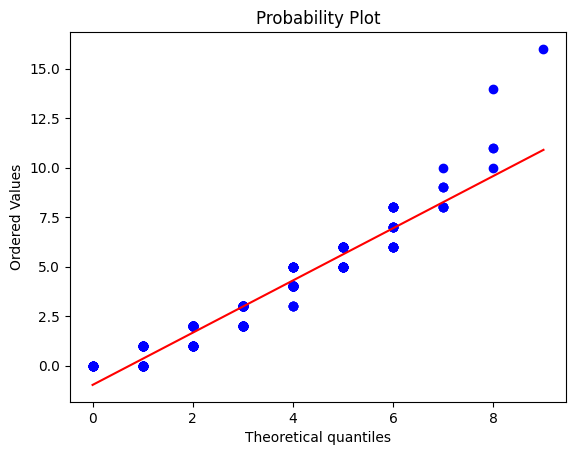

Luxembourg


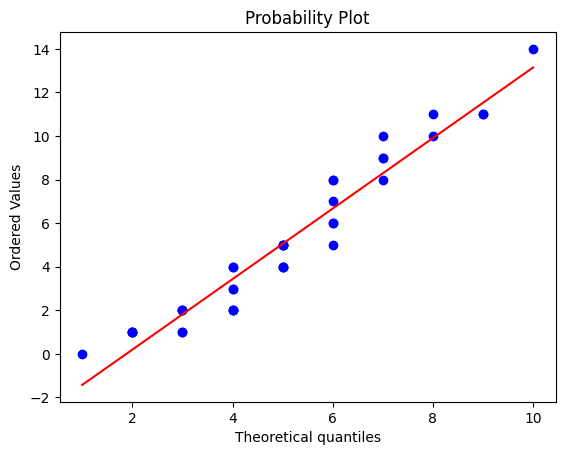

Malaysia


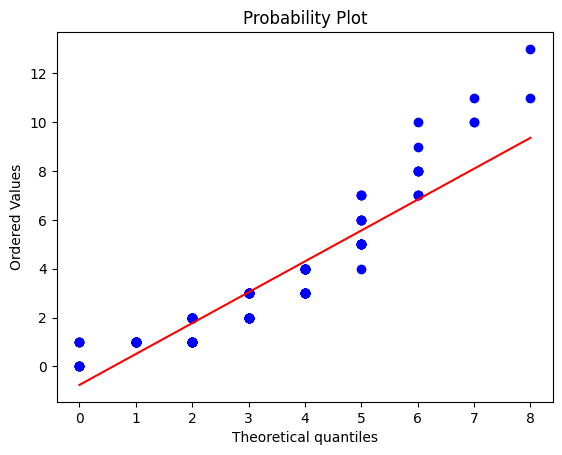

Malta


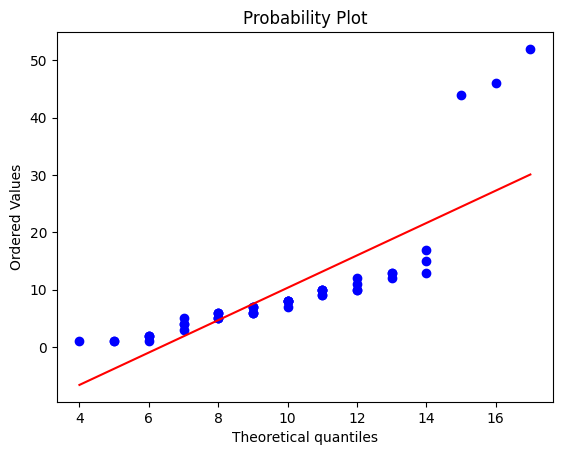

Mexico


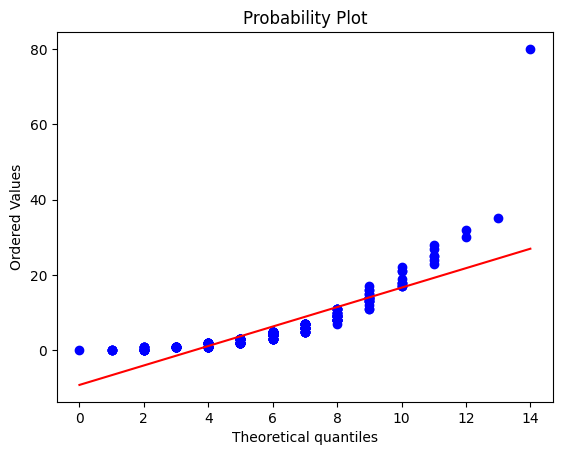

Moldova


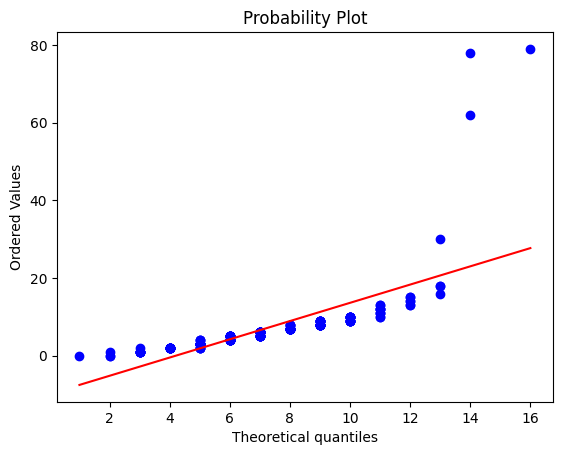

Morocco


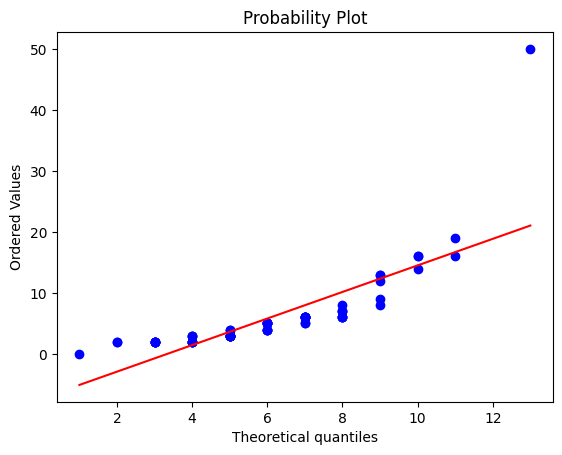

Panama


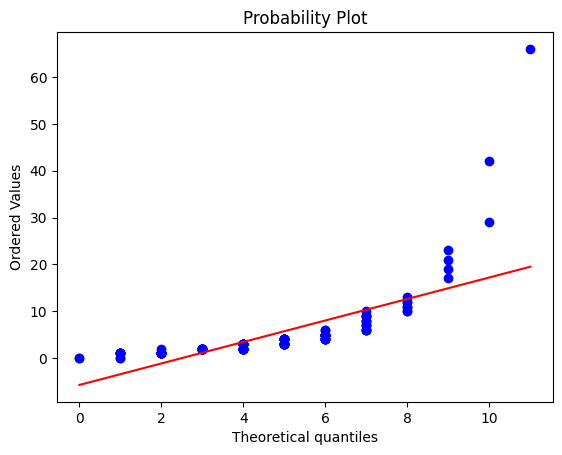

Peru


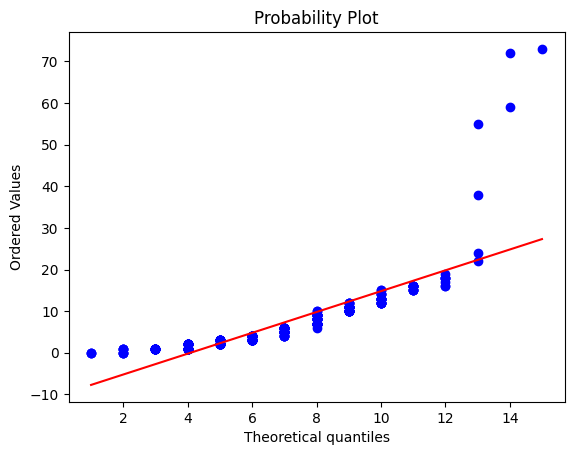

Philippines


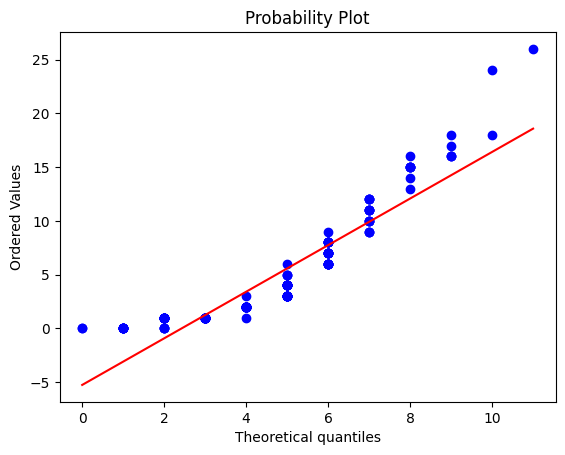

Poland


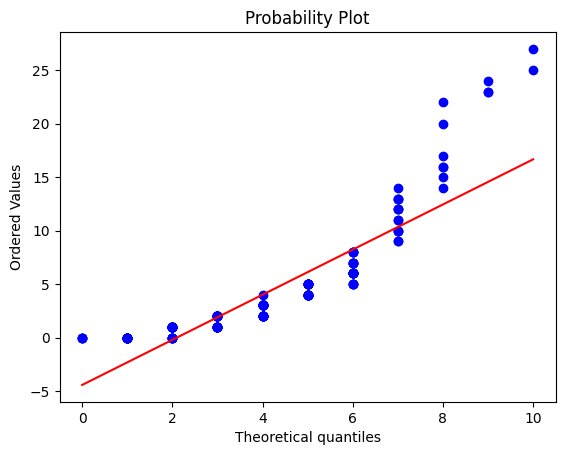

Portugal


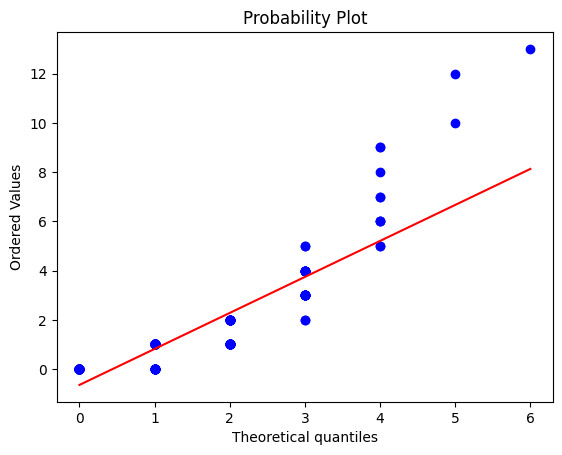

Qatar


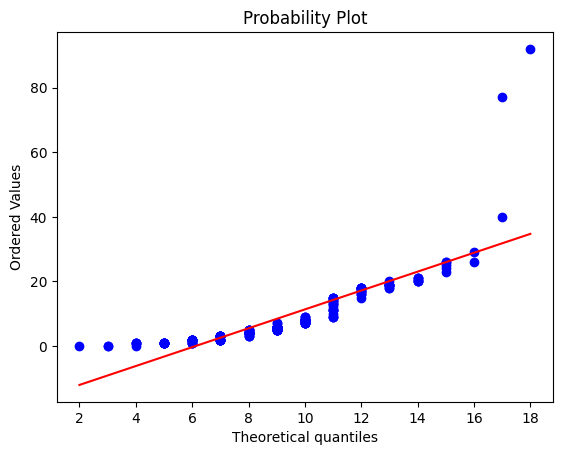

Saudi Arabia


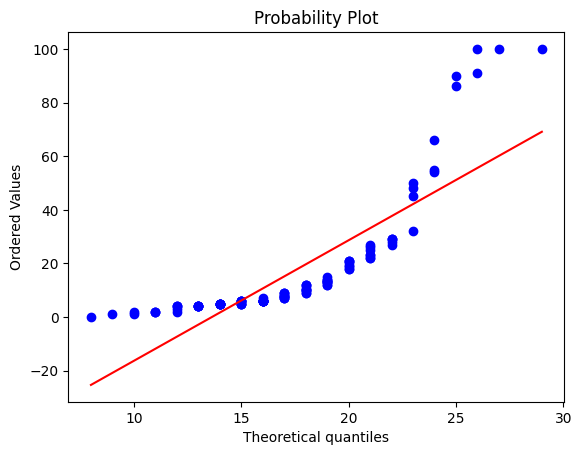

Singapore


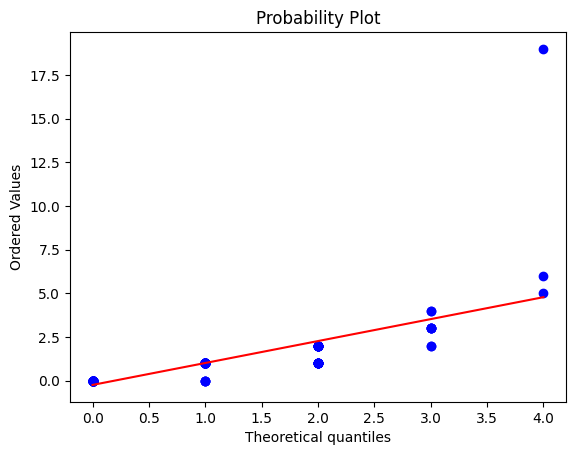

Slovak Republic


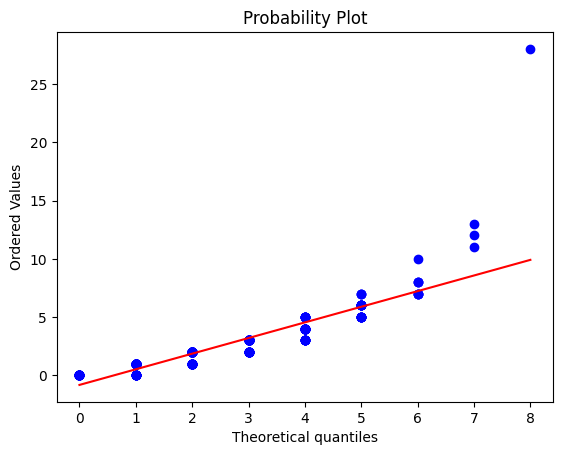

Spain


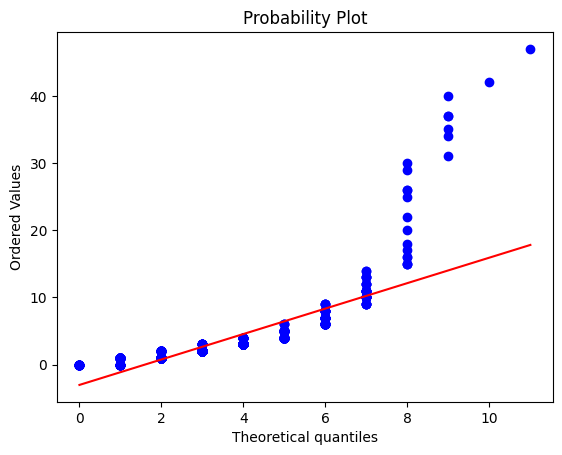

Sweden


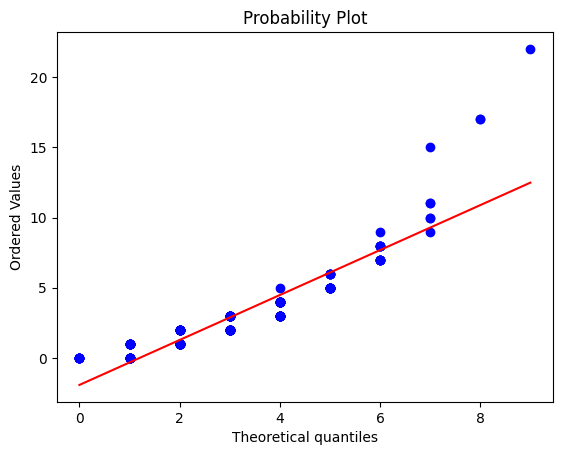

Switzerland


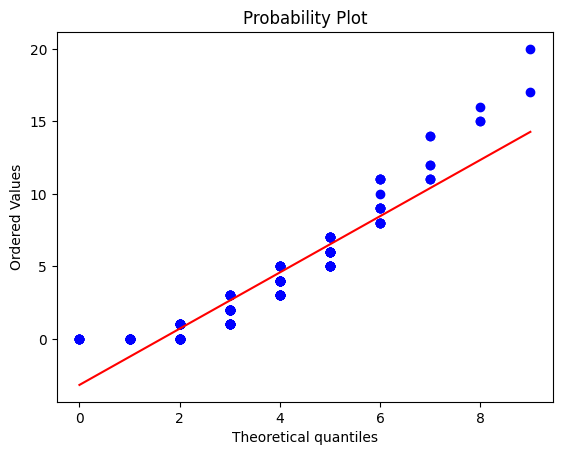

Thailand


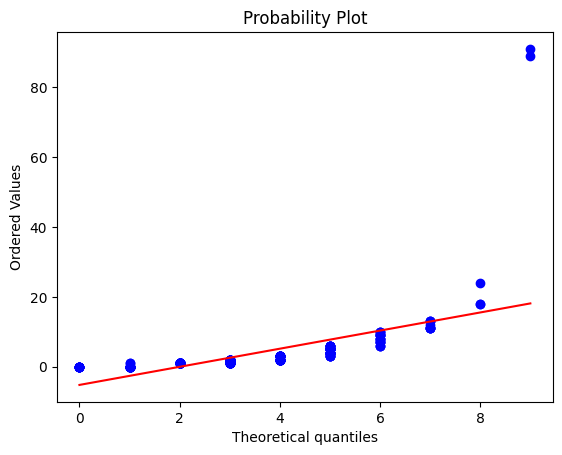

United Arab Emirates


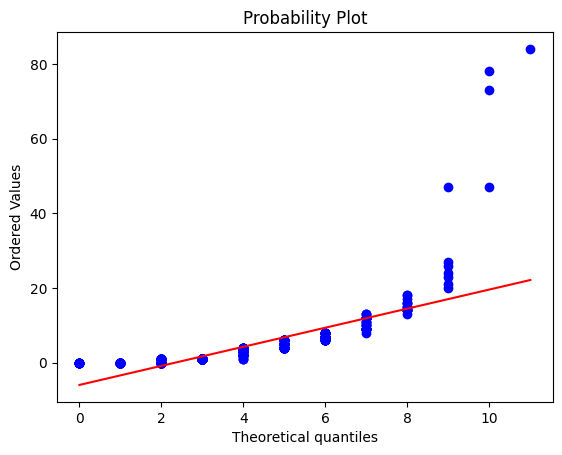

Turkey


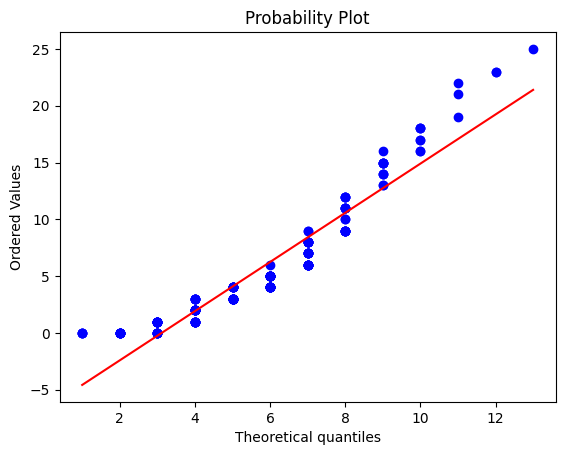

United Kingdom


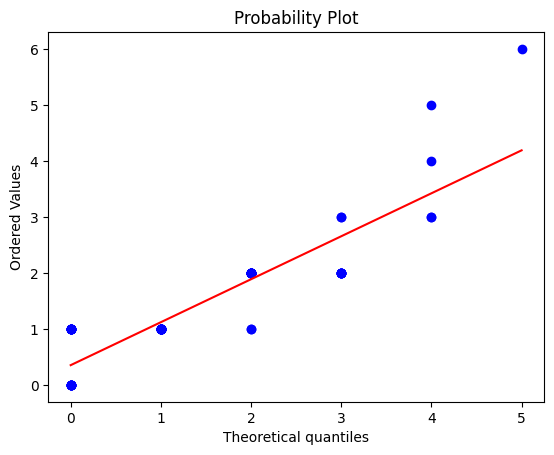

United States


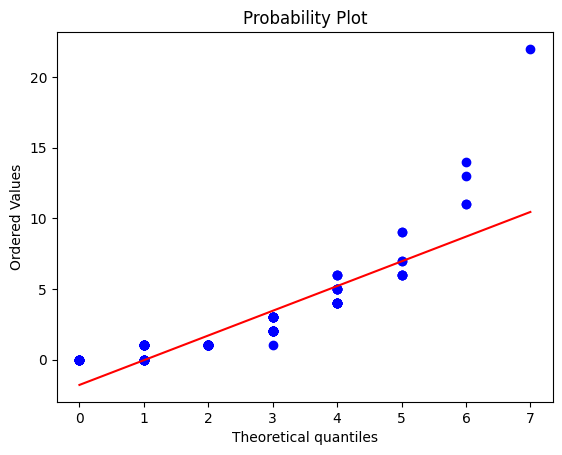

Uruguay


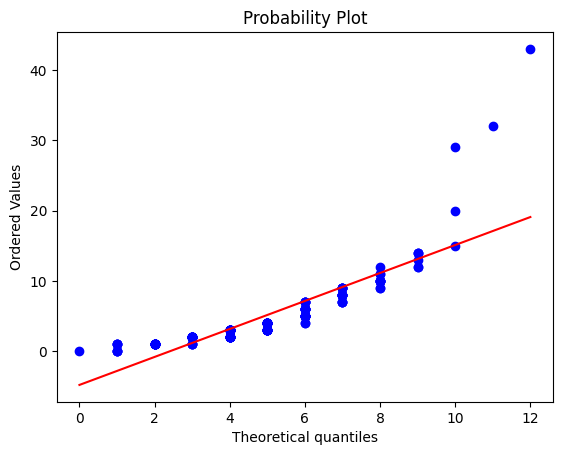

B-S-J-Z (China)


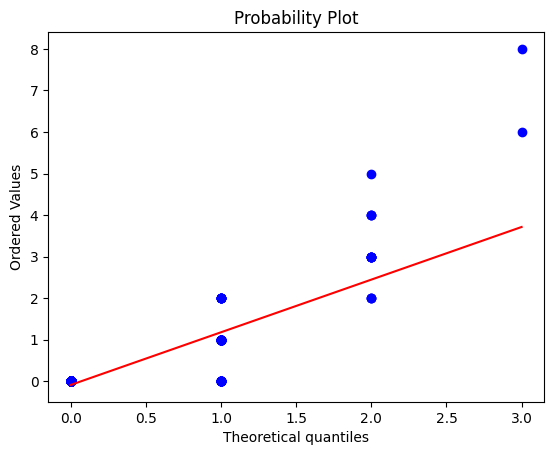

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

for j in df.CNT.unique():
    print(j)
    observed_data = df.loc[df.CNT==j, 'Y_MATH']
    #print(len(observed_data))
    lambda_poi = np.mean(observed_data)
    scipy.stats.probplot(observed_data, dist='poisson', sparams=(lambda_poi,), plot=plt)
    plt.show()

# Other analysis: Lilliefors test & Kolmogorov Smirnov test

https://stats.stackexchange.com/questions/555291/goodness-of-fit-for-presumably-poisson-distributed-data

https://en.wikipedia.org/wiki/Lilliefors_test based on https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test


In [7]:
def ecdf(x):
    sx = np.sort(x)
    n = sx.size
    sy = np.arange(1,n+1)/n
    return sx,sy

def lill_poisson(x,sim=10000,seed=10):
    n = len(x)
    nu = np.arange(1.0,n+1)/n
    nm = np.arange(0.0,n)/n
    # Fit parameters
    m = x.mean()
    fp = poisson(m) # frozen Poisson
    # in function for KS stat
    def ks(obs):
        x = np.sort(obs)
        cv = fp.cdf(x)
        Dp = (nu - cv).max()
        Dm = (cv - nm).max()
        return np.max([Dp,Dm])
    # KS stat observed
    ks_obs = ks(x)
    # Generate simulation
    np.random.seed(seed)
    sa = np.zeros(sim)
    for i in range(sim):
        s = fp.rvs(n)
        sa[i] = ks(s)
    # calculate p-value
    p_val = np.append(sa,ks_obs).argsort()[-1]/sim
    return ks_obs, p_val, sa

Albania


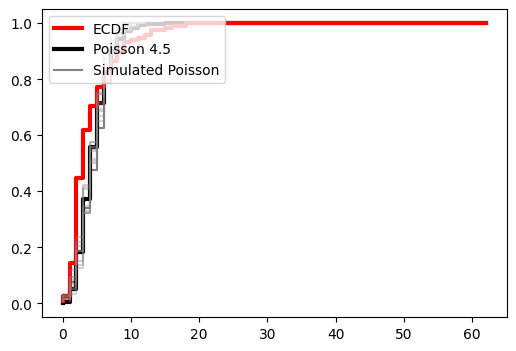

KS Stat: 0.27, p-value 0.39
Baku (Azerbaijan)


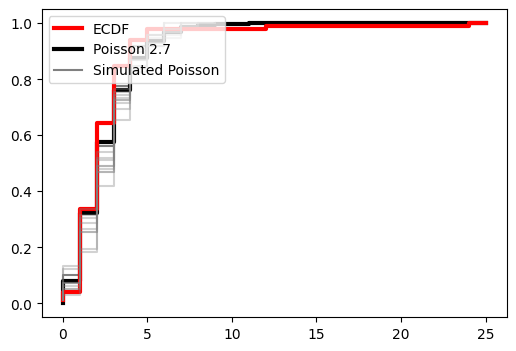

KS Stat: 0.22, p-value 0.13
Argentina


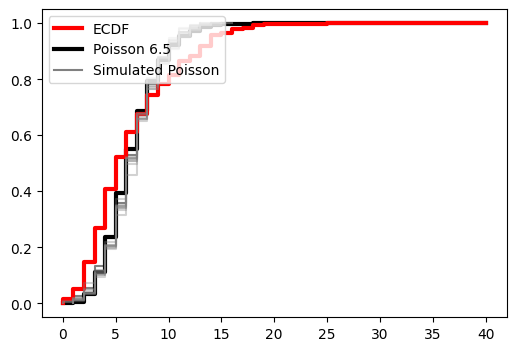

KS Stat: 0.19, p-value 0.85
Australia


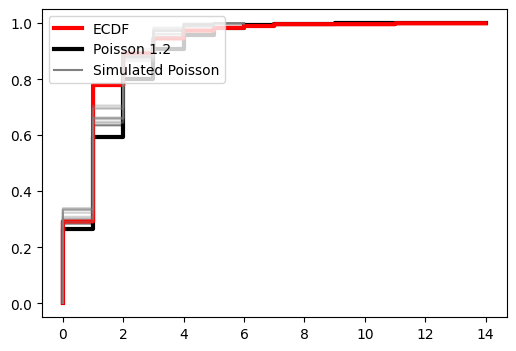

KS Stat: 0.38, p-value 0.52
Brazil


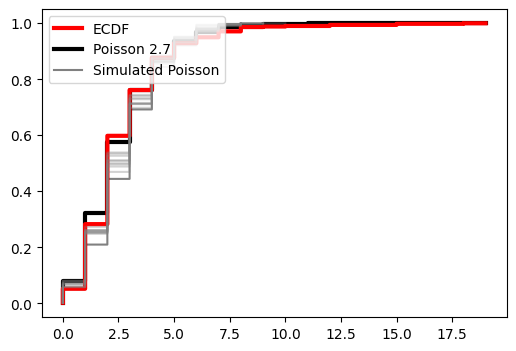

KS Stat: 0.22, p-value 0.14
Brunei Darussalam


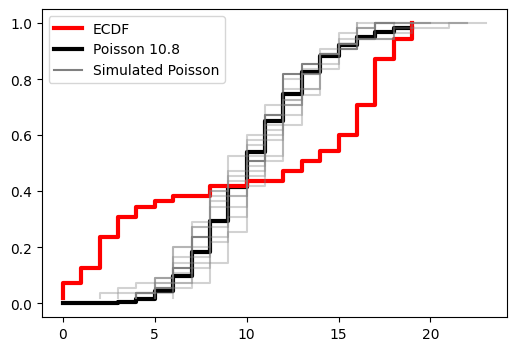

KS Stat: 0.39, p-value 1.00
Chile


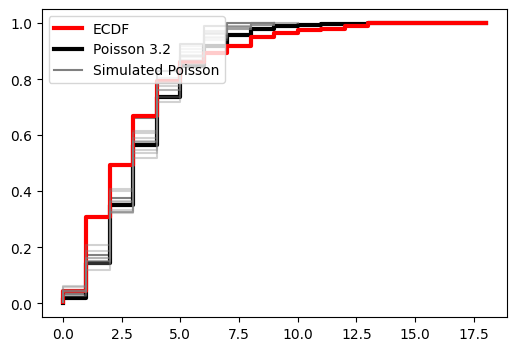

KS Stat: 0.14, p-value 0.81
Chinese Taipei


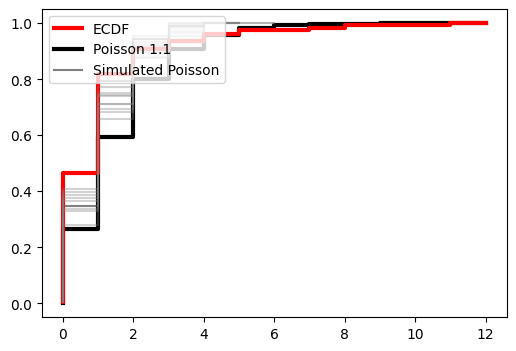

KS Stat: 0.35, p-value 0.11
Colombia


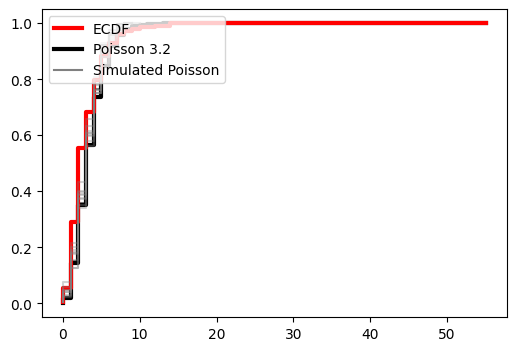

KS Stat: 0.16, p-value 0.81
Costa Rica


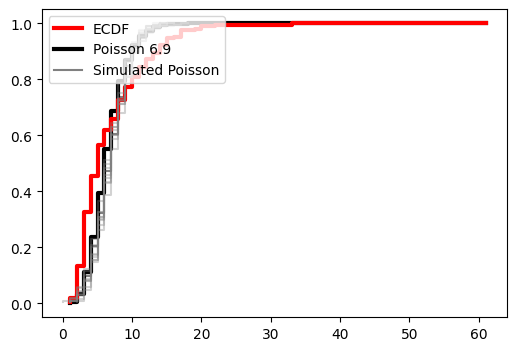

KS Stat: 0.27, p-value 0.38
Denmark


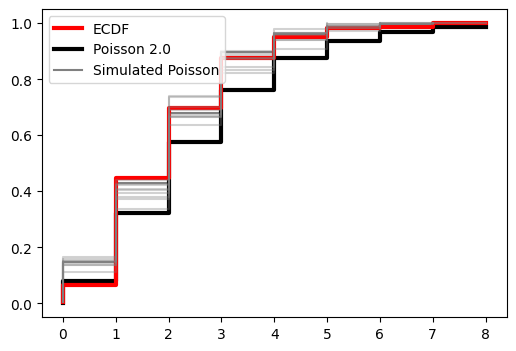

KS Stat: 0.34, p-value 0.80
Dominican Republic


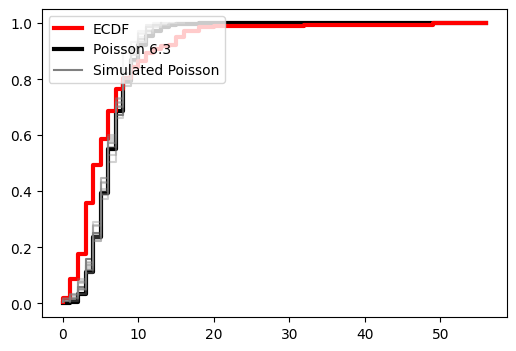

KS Stat: 0.24, p-value 0.40
Estonia


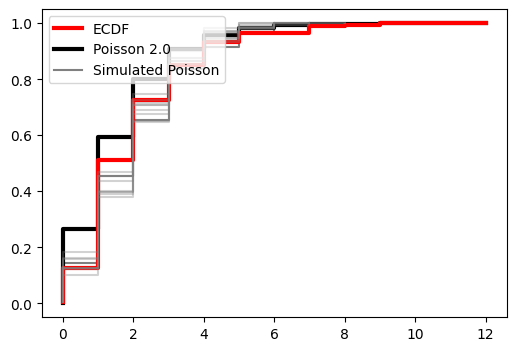

KS Stat: 0.29, p-value 0.38
France


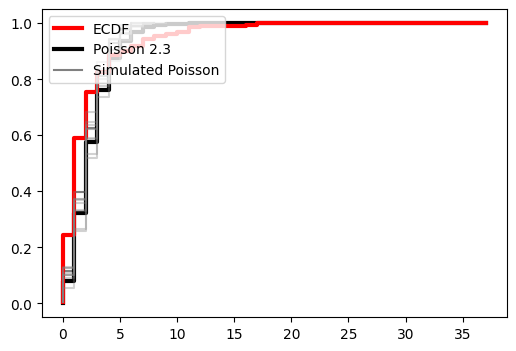

KS Stat: 0.25, p-value 0.39
Georgia


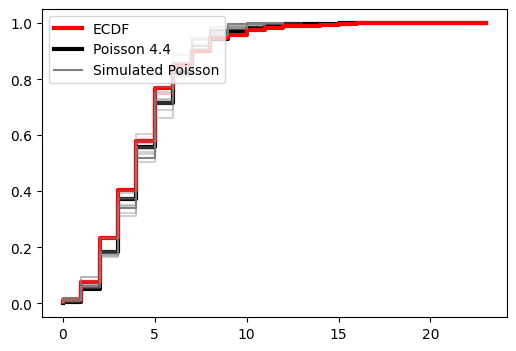

KS Stat: 0.15, p-value 0.44
Greece


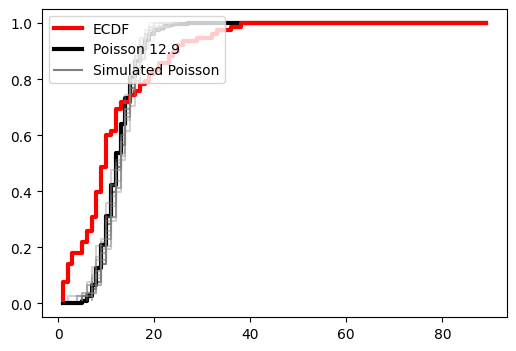

KS Stat: 0.33, p-value 1.00
Indonesia


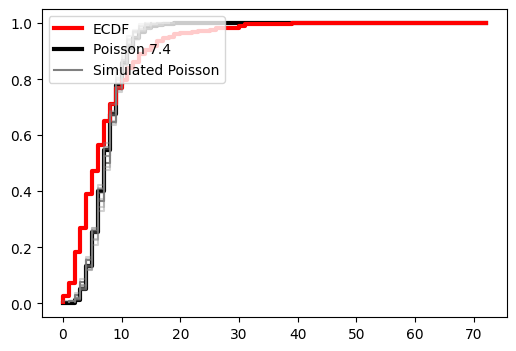

KS Stat: 0.25, p-value 0.10
Ireland


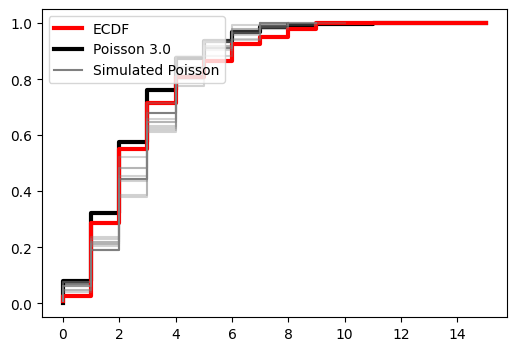

KS Stat: 0.18, p-value 0.06
Israel


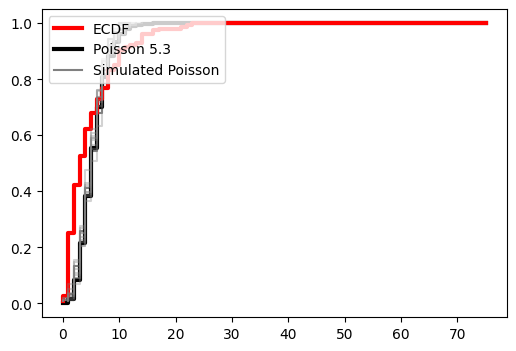

KS Stat: 0.31, p-value 1.00
Italy


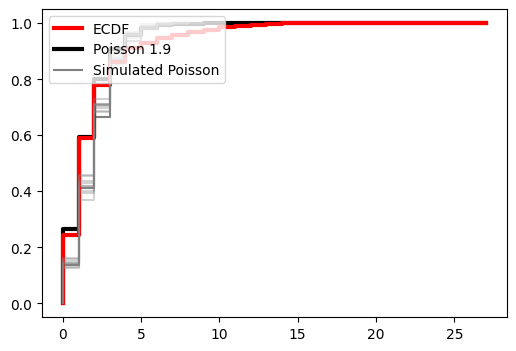

KS Stat: 0.18, p-value 0.34
Japan


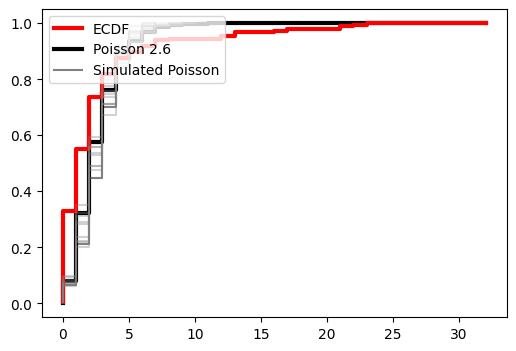

KS Stat: 0.28, p-value 0.05
Kazakhstan


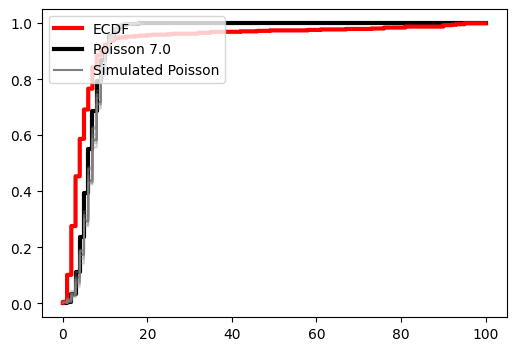

KS Stat: 0.41, p-value 1.00
Jordan


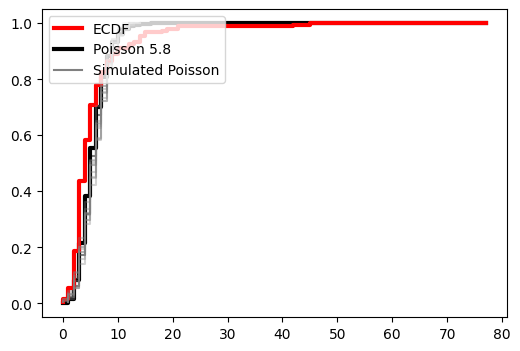

KS Stat: 0.26, p-value 0.15
Lebanon


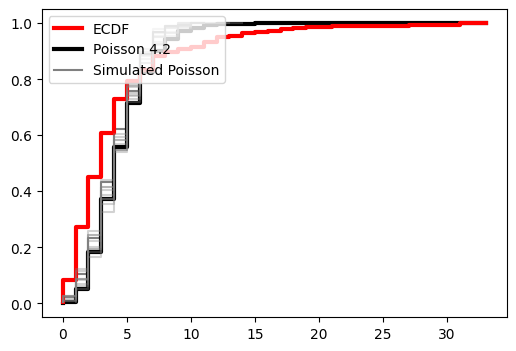

KS Stat: 0.23, p-value 0.22
Lithuania


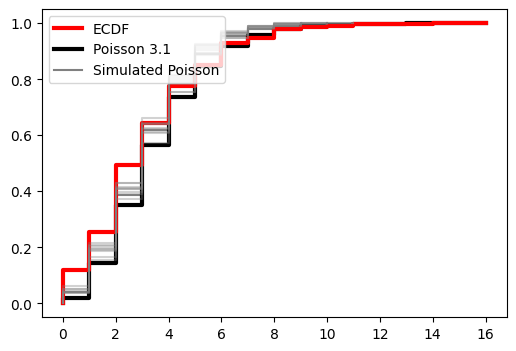

KS Stat: 0.16, p-value 0.18
Luxembourg


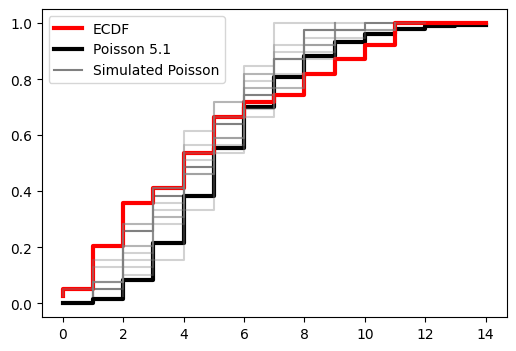

KS Stat: 0.21, p-value 0.31
Malaysia


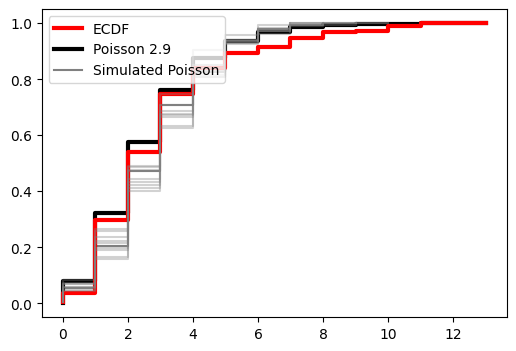

KS Stat: 0.18, p-value 0.24
Malta


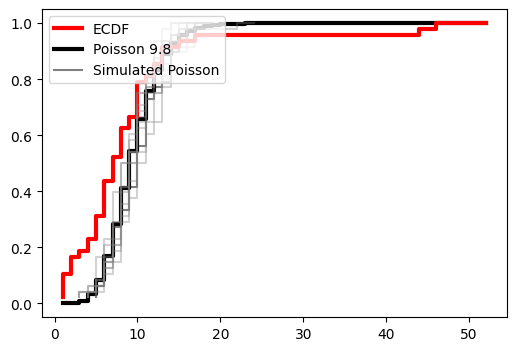

KS Stat: 0.27, p-value 0.78
Mexico


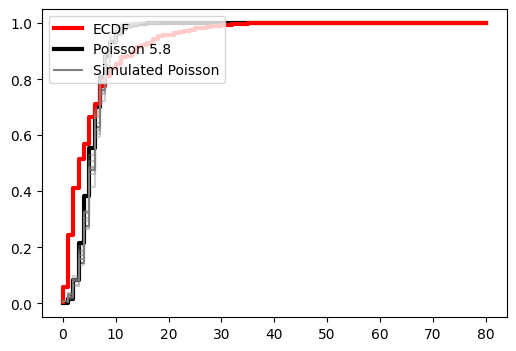

KS Stat: 0.34, p-value 1.00
Moldova


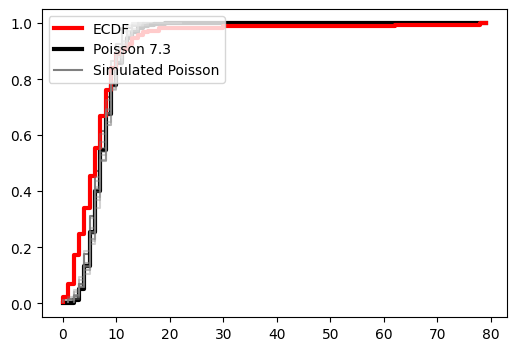

KS Stat: 0.19, p-value 0.47
Morocco


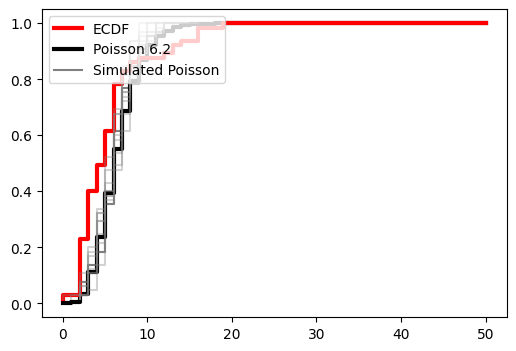

KS Stat: 0.25, p-value 0.16
Panama


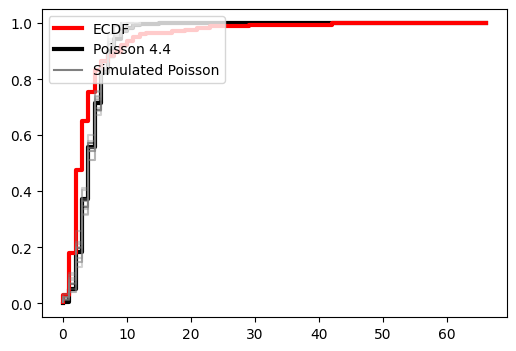

KS Stat: 0.29, p-value 0.16
Peru


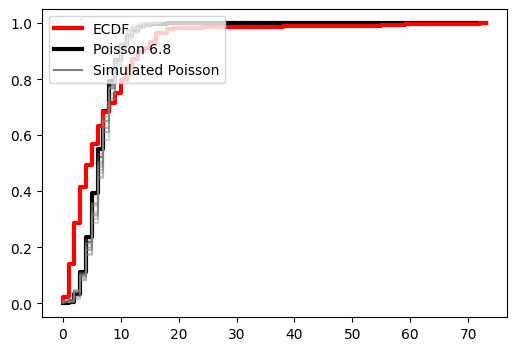

KS Stat: 0.32, p-value 1.00
Philippines


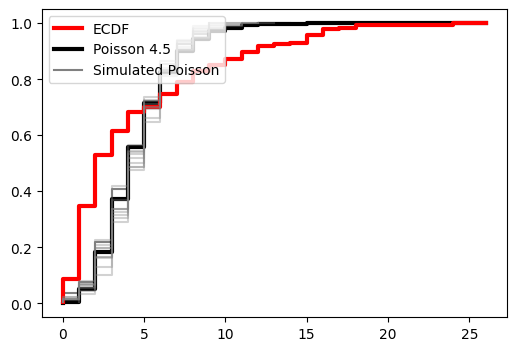

KS Stat: 0.35, p-value 1.00
Poland


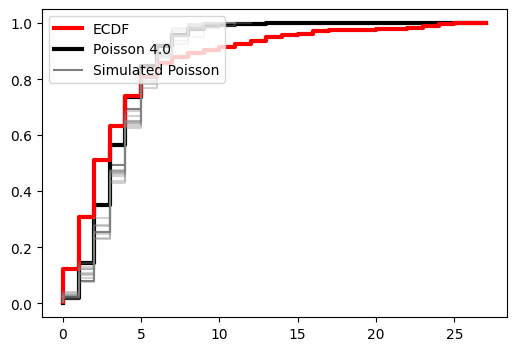

KS Stat: 0.27, p-value 0.22
Portugal


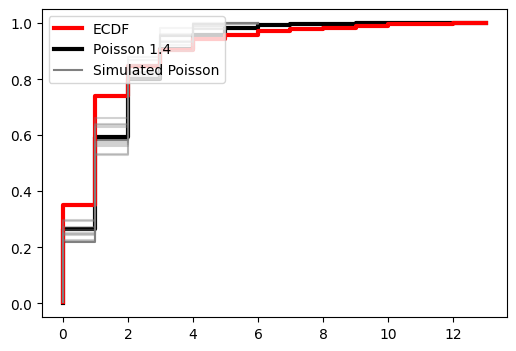

KS Stat: 0.25, p-value 0.63
Qatar


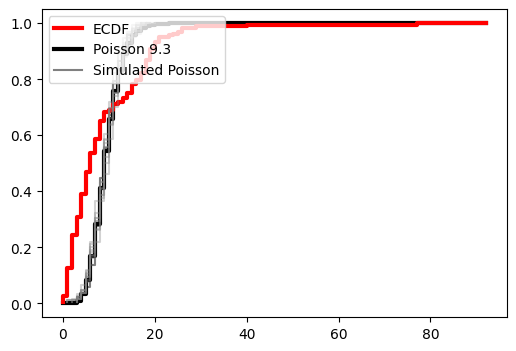

KS Stat: 0.37, p-value 1.00
Saudi Arabia


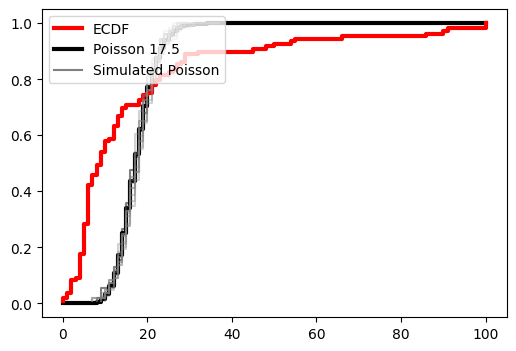

KS Stat: 0.53, p-value 1.00
Singapore


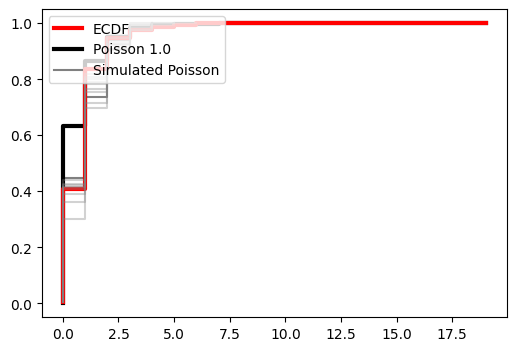

KS Stat: 0.38, p-value 0.95
Slovak Republic


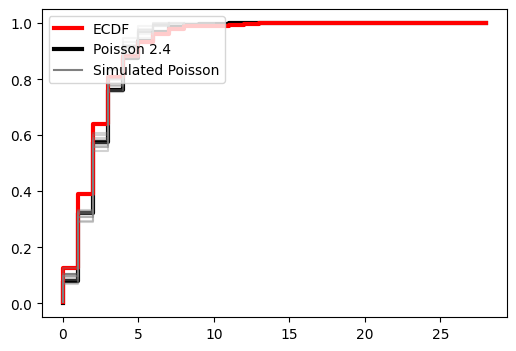

KS Stat: 0.18, p-value 0.51
Spain


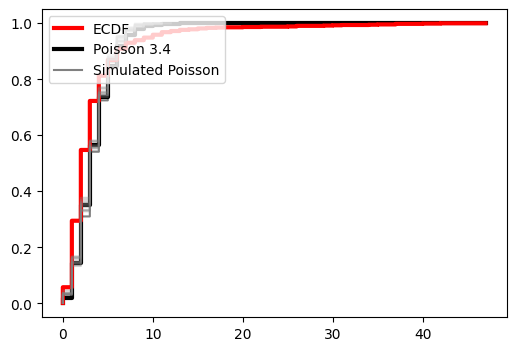

KS Stat: 0.21, p-value 0.75
Sweden


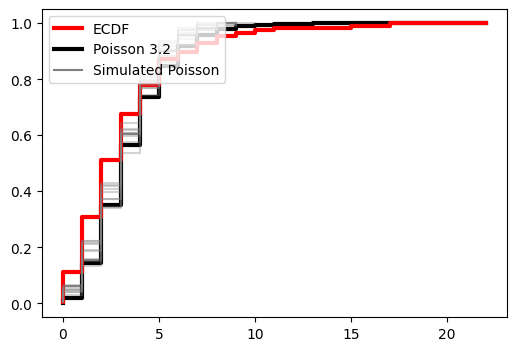

KS Stat: 0.14, p-value 0.10
Switzerland


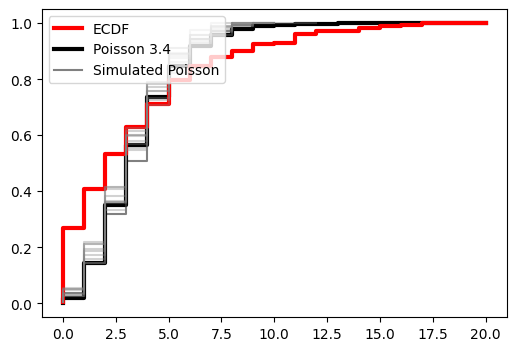

KS Stat: 0.25, p-value 1.00
Thailand


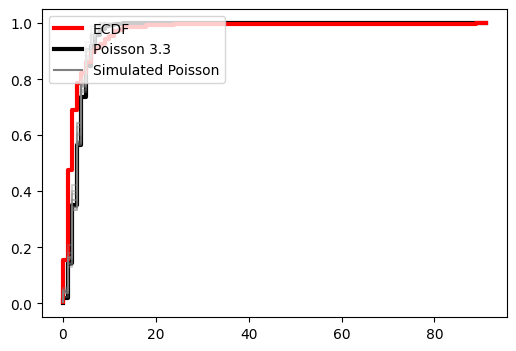

KS Stat: 0.32, p-value 0.67
United Arab Emirates


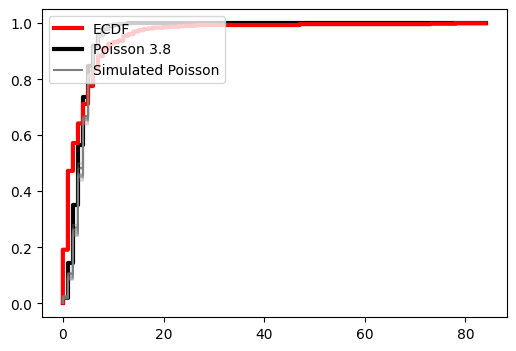

KS Stat: 0.37, p-value 1.00
Turkey


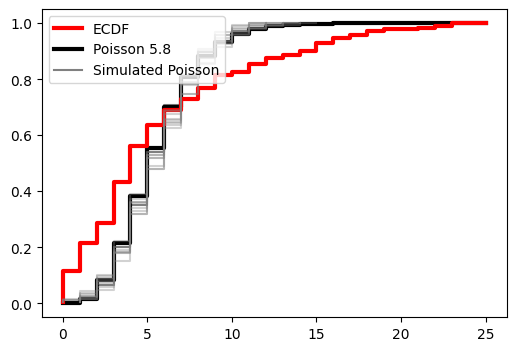

KS Stat: 0.26, p-value 0.17
United Kingdom


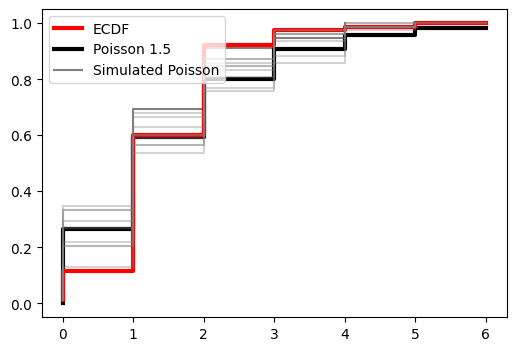

KS Stat: 0.46, p-value 0.86
United States


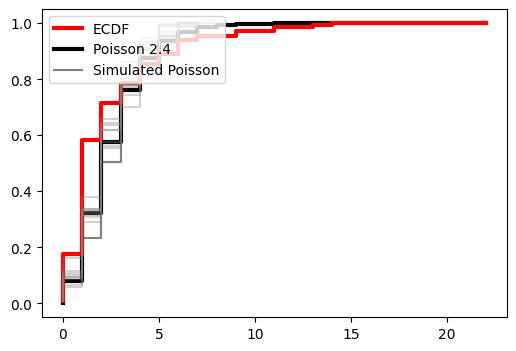

KS Stat: 0.27, p-value 0.48
Uruguay


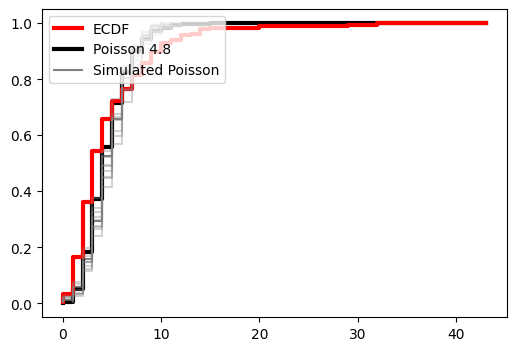

KS Stat: 0.25, p-value 0.43
B-S-J-Z (China)


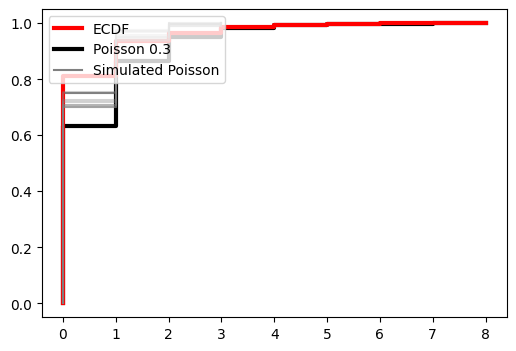

KS Stat: 0.72, p-value 1.00


In [8]:
for i in df.CNT.unique():
    print(i)
    obs = df.loc[df.CNT==i, 'Y_MATH']

    fig, ax = plt.subplots(figsize=(6,4))
    # CDF for observed data
    ecdf_x,ecdf_y = ecdf(obs)
    ax.step(ecdf_x,ecdf_y,color='red',label='ECDF', linewidth=3,zorder=3)

    # CDF for hypothetical poisson
    pcdf_x = np.arange(obs.min(),obs.max()+1)
    pcdf_y = 1 - poisson.cdf(obs.mean(),pcdf_x)
    ax.step(pcdf_x,pcdf_y, color='k',linewidth=3, label=f'Poisson {obs.mean():.1f}',zorder=2)

    # Random variates of same size as obs
    for i in range(10):
        randp = poisson.rvs(obs.mean(),size=len(obs))
        rcdf_x,rcdf_y = ecdf(randp)
        if i == 0:
            ax.step(rcdf_x,rcdf_y, color='grey', label=f'Simulated Poisson',zorder=1)
        else:
            ax.step(rcdf_x,rcdf_y, color='grey',alpha=0.35,zorder=3)

    ax.legend(loc='upper left')
    plt.show()

    kstat, pval, svals = lill_poisson(obs)
    print(f'KS Stat: {kstat:0.2f}, p-value {pval:0.2f}')